In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Multiply
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

from scipy.stats import pointbiserialr, permutation_test

## Read

In [3]:
csv_path = 'combined.csv'
df = pd.read_csv(csv_path)

C:\Users\thead\AppData\Local\Temp\ipykernel_25148\739053078.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [5]:
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')

In [6]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [7]:
# convert to booleans
df[stresses] = df[stresses].astype(bool)

In [8]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [9]:
df['Stressed'] = df[stresses].any(axis=1)

In [10]:
# permanova

## Visualizations

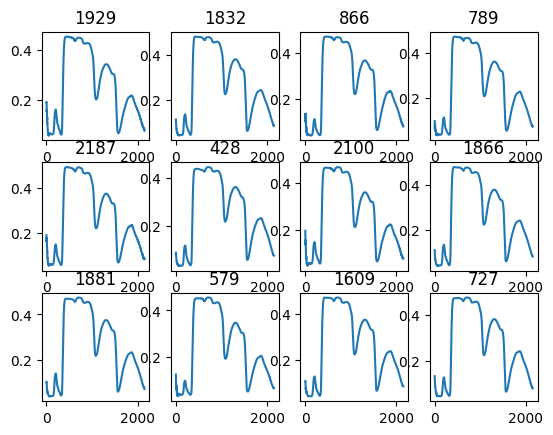

In [11]:
figs, axs = plt.subplots(3, 4)

for row in axs:
    for ax in row:
        i = np.random.randint(0, df.shape[1])
        ax.set_title(i)
        ax.plot(df[spec_cols].values[i])

### PCR

In [12]:
pca = PCA(n_components=50)
x_pca = pca.fit_transform(df[spec_cols].values)
pca.explained_variance_ratio_.sum()

0.9998102010311513

Text(0.5, 1.0, 'PCA Performance vs # Dimensions')

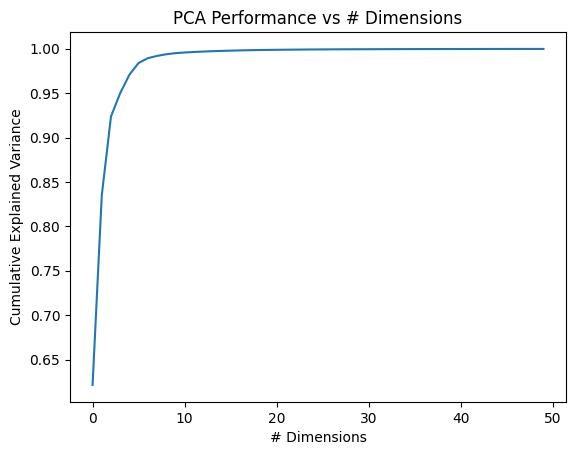

In [13]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('# Dimensions')
plt.title('PCA Performance vs # Dimensions')

In [14]:
x_pca[df['Stressed'].values][:,:2].mean(axis=0)

array([-0.08802085,  0.02164633])

(-1.0, 1.5)

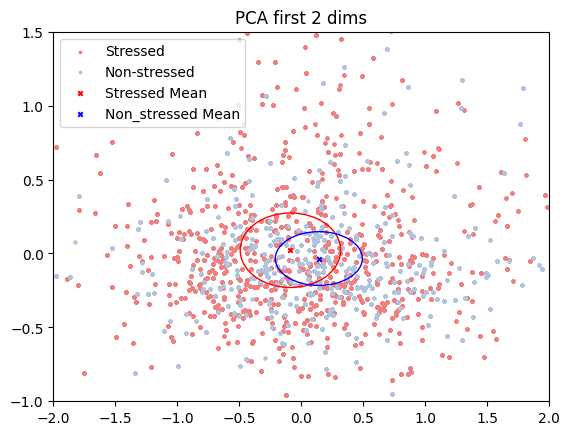

In [15]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(x_pca[df['Stressed'].values][:,0], x_pca[df['Stressed'].values][:,1], s=3, c='lightcoral', label='Stressed')
ax.scatter(x_pca[~df['Stressed'].values][:,0], x_pca[~df['Stressed'].values][:,1], s=3, c='lightsteelblue', label='Non-stressed')

ax.scatter(x_pca[df['Stressed'].values][:,0].mean(), x_pca[df['Stressed'].values][:,1].mean(), s=10, c='red', label='Stressed Mean', marker='x')
ax.scatter(x_pca[~df['Stressed'].values][:,0].mean(), x_pca[~df['Stressed'].values][:,1].mean(), s=10, c='blue', label='Non_stressed Mean', marker='x')


stressed_ellipse = Ellipse(
    xy=x_pca[df['Stressed'].values][:,:2].mean(axis=0),
    width=x_pca[df['Stressed'].values][:,0].std(),
    height=x_pca[df['Stressed'].values][:,1].std(),
    fill=False,
    edgecolor='red',
)

non_stressed_ellipse = Ellipse(
    xy=x_pca[~df['Stressed'].values][:,:2].mean(axis=0),
    width=x_pca[~df['Stressed'].values][:,0].std(),
    height=x_pca[~df['Stressed'].values][:,1].std(),
    fill=False,
    edgecolor='blue'
)


ax.add_patch(stressed_ellipse)
ax.add_patch(non_stressed_ellipse)

ax.legend()
ax.set_title('PCA first 2 dims')
ax.set_xlim((-2, 2))
ax.set_ylim((-1, 1.5))

## Drop Resolution

In [16]:
# drop resolution

def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [17]:
blur_factor = 10
blur_x = drop_res(df[spec_cols].values, blur_factor=blur_factor)

### Gaussian Blur

In [18]:
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-.5 * (x-mu)*(x-mu)/(sigma*sigma))

In [19]:
gaussian_kernel = gaussian(np.linspace(-1, 1, 100), mu=0, sigma=.3)
gaussian_kernel /= np.linalg.norm(gaussian_kernel)

## Filter for stressed

### Correlations

In [20]:
spec_corrs = np.array([
    pointbiserialr(df['Stressed'].values, blur_x[:,i]).statistic
    for i in range(blur_x.shape[1])
])

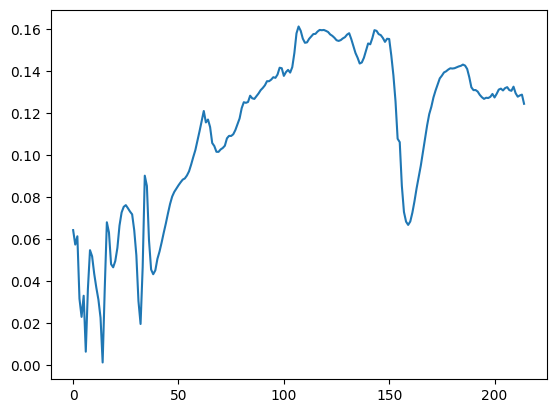

In [21]:
plt.plot(np.abs(spec_corrs))

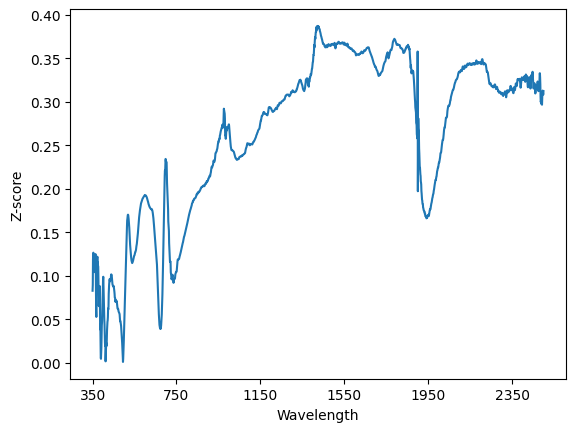

In [22]:
# Plotting how many standard deviations out the average stressed amplitude is from the average non-stressed amplitude at a given wavelength

spec_n_std = df[~df['Stressed']][spec_cols].std()
spec_n_mean = df[~df['Stressed']][spec_cols].mean()
spec_mean = df[df['Stressed']][spec_cols].mean()

y = ((spec_mean - spec_n_mean).abs() / spec_n_std).values
plt.plot(((spec_mean - spec_n_mean).abs() / spec_n_std).values)
wave_range = np.arange(0, y.shape[0]-1, 400, dtype=int)
plt.xticks(wave_range, [spec_cols[i][1:] for i in wave_range])
plt.xlabel('Wavelength')
plt.ylabel('Z-score');

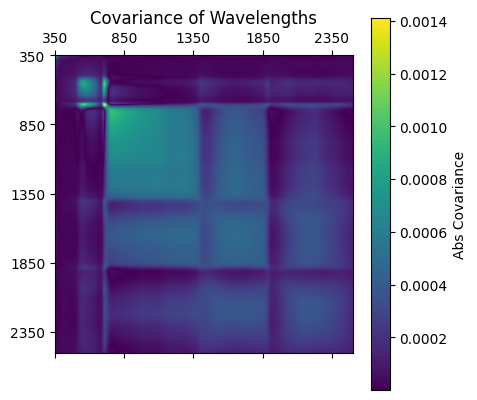

In [23]:
spec_inter_cov = df[spec_cols].cov()

plt.matshow(spec_inter_cov.abs().values)
plt.title('Covariance of Wavelengths')
plt.colorbar(label='Abs Covariance')

lambda_range = np.arange(0, spec_inter_cov.shape[0], 500)
plt.xticks(lambda_range, [spec_cols[i][1:] for i in lambda_range]);
plt.yticks(lambda_range, [spec_cols[i][1:] for i in lambda_range]);

### Gaussian

In [24]:
spec_n_std = df[~df['Stressed']][spec_cols].std()
spec_n_mean = df[~df['Stressed']][spec_cols].mean()

In [25]:
def gaussian_predict(x, std, mean, z_thresh=3, n_thresh=2):
    return (np.abs((x - mean)) > (std * z_thresh)).sum(axis=1) > n_thresh

In [26]:
y_pred = gaussian_predict(df[spec_cols].values, spec_n_std.values, spec_n_mean.values, z_thresh=2, n_thresh=2)
(y_pred == df['Stressed'].values).mean()

0.5180081163341225

In [27]:
y_pred = gaussian_predict(blur_x, blur_x[~df['Stressed']].std(axis=0), blur_x[~df['Stressed']].mean(axis=0), z_thresh=2, n_thresh=2)
(y_pred == df['Stressed'].values).mean()

0.5224044639837674

#### Optimize

In [28]:
n_searches = 500
z_thresh_lim = 4
n_thresh_lim = 10

blur_n_std =  blur_x[~df['Stressed']].std(axis=0)
blur_n_mean = blur_x[~df['Stressed']].mean(axis=0)

search_space = np.random.random_sample((n_searches, 2)) * np.array([z_thresh_lim, n_thresh_lim])
accuracies = np.empty((n_searches,))

for i in range(search_space.shape[0]):
    y_pred = gaussian_predict(blur_x, blur_n_std, blur_n_mean, z_thresh=search_space[i,0], n_thresh=search_space[i,1])
    accuracies[i] = (df['Stressed'].values == y_pred).mean()

'z_thresh: 1.1022020963456978, n_thresh: 9.170281121858743, accuracy: 0.6467703753804531'

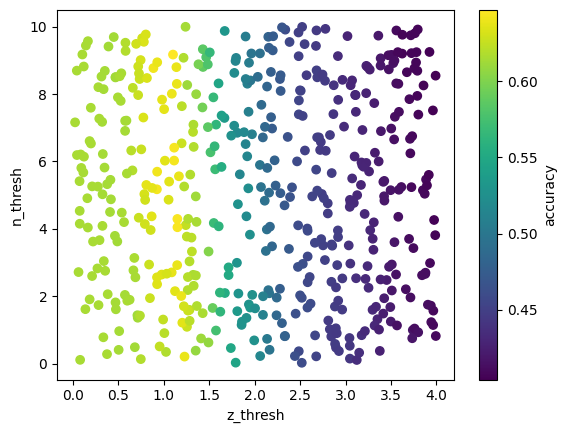

In [29]:
plt.scatter(search_space[:,0], search_space[:,1], c=accuracies)
plt.colorbar(label='accuracy')
plt.xlabel('z_thresh')
plt.ylabel('n_thresh')

z_thresh, n_thresh = search_space[accuracies.argmax()]
f'z_thresh: {z_thresh}, n_thresh: {n_thresh}, accuracy: {accuracies.max()}'

### Preprocess

In [30]:
fuzzy_win = 5
fuzzy_dx_kernel = np.hstack((np.ones(fuzzy_win) * -1/fuzzy_win, np.ones(fuzzy_win)/fuzzy_win))

fuzzy_dx = np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=df[spec_cols].values, axis=1)
fuzzy_dx2 = np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=fuzzy_dx, axis=1)
fuzzy_dx3 = np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=fuzzy_dx2, axis=1)

Text(0.5, 1.0, 'Fuzzy Derivative Kernel')

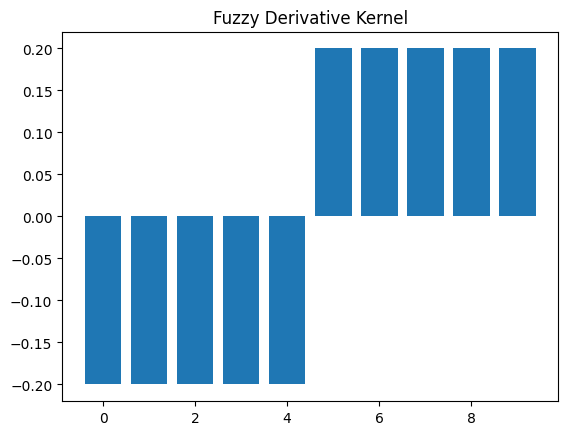

In [31]:
plt.bar(np.arange(0, fuzzy_dx_kernel.shape[0], 1), fuzzy_dx_kernel)
plt.title('Fuzzy Derivative Kernel')

<BarContainer object of 42 artists>

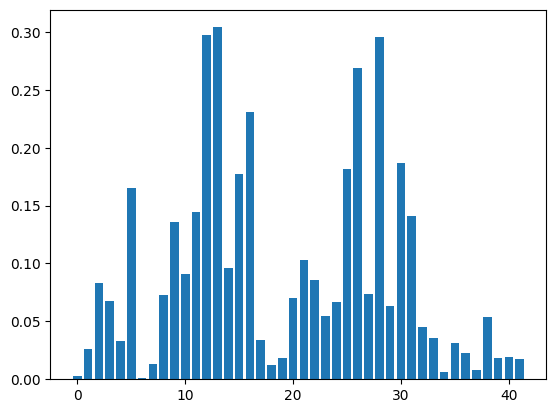

In [32]:
blur_fuzzy_x = drop_res(fuzzy_dx3, blur_factor=50)

spec_corrs = np.array([
    pointbiserialr(df['Stressed'].values, blur_fuzzy_x[:,i]).statistic
    for i in range(blur_fuzzy_x.shape[1])
])

plt.bar(np.arange(0, spec_corrs.shape[0], 1), np.abs(spec_corrs))

### NN

In [33]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

In [64]:
# x = df[spec_cols].values
# x = blur_x
blur_factor = 5
x = drop_res(fuzzy_dx3, blur_factor=blur_factor)
y = df['Stressed']

x /= x.max()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [35]:
simple = Sequential([
    Conv1D(20, 1, input_shape=(x_train.shape[1],1), kernel_regularizer=L2(.001)),
    MaxPooling1D(5),
    Flatten(),
    Dense(5, kernel_regularizer=L2(.01)),
    Dense(1),
])
simple.compile(optimizer=Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
simple_history = simple.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[ReduceLROnPlateau()])

Epoch 1/50


592/592 [==============================] - 2s 3ms/step - loss: 9.5090 - accuracy: 0.3856 - val_loss: 9.5459 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 2/50
592/592 [==============================] - 2s 3ms/step - loss: 9.4794 - accuracy: 0.3856 - val_loss: 9.5425 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 3/50
592/592 [==============================] - 2s 3ms/step - loss: 9.4783 - accuracy: 0.3856 - val_loss: 9.5421 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 4/50
592/592 [==============================] - 1s 2ms/step - loss: 9.4779 - accuracy: 0.3856 - val_loss: 9.5418 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 5/50
592/592 [==============================] - 2s 3ms/step - loss: 9.4777 - accuracy: 0.3856 - val_loss: 9.5416 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 6/50
592/592 [==============================] - 1s 2ms/step - loss: 9.4775 - accuracy: 0.3856 - val_loss: 9.5414 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 7/50
592/592 [========================

(0.0, 1.0)

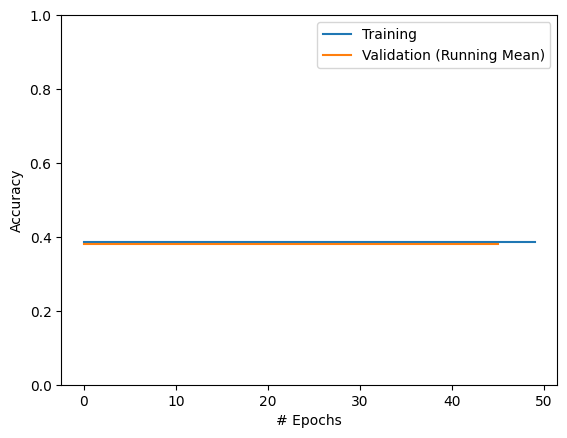

In [37]:
fig = plt.figure()
ax = plt.gca()

ax.plot(simple_history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(simple_history.history['val_accuracy']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))

<BarContainer object of 20 artists>

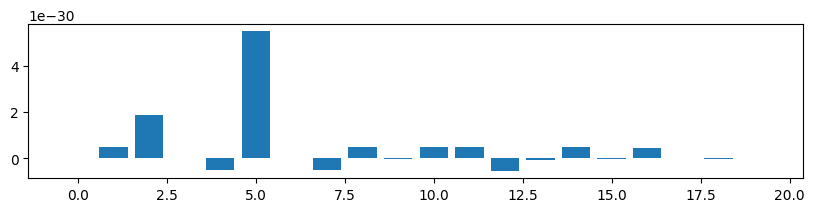

In [38]:
fig, ax = plt.subplots(figsize=(10,2))
dense_weights = simple.get_layer(index=0).weights[0][0][0]
ax.bar(np.arange(0, dense_weights.shape[0], 1), dense_weights)

### Autoencoder

In [39]:
ae_model = Sequential([
    Dense(10, input_shape=(x_train.shape[1],), kernel_regularizer=L2(.00)),
    Dense(1),
])
ae_model.compile(optimizer=Adam(.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
ae_history = ae_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
592/592 [==============================] - 1s 1ms/step - loss: 0.7074 - accuracy: 0.6047 - val_loss: 0.5958 - val_accuracy: 0.7274
Epoch 2/50
592/592 [==============================] - 1s 1ms/step - loss: 0.5660 - accuracy: 0.7488 - val_loss: 0.5413 - val_accuracy: 0.7585
Epoch 3/50
592/592 [==============================] - 1s 1ms/step - loss: 0.5186 - accuracy: 0.7602 - val_loss: 0.5070 - val_accuracy: 0.7703
Epoch 4/50
592/592 [==============================] - 1s 1ms/step - loss: 0.4889 - accuracy: 0.7669 - val_loss: 0.4754 - val_accuracy: 0.7728
Epoch 5/50
592/592 [==============================] - 1s 1ms/step - loss: 0.4665 - accuracy: 0.7706 - val_loss: 0.4647 - val_accuracy: 0.7623
Epoch 6/50
592/592 [==============================] - 1s 1ms/step - loss: 0.4482 - accuracy: 0.7745 - val_loss: 0.4427 - val_accuracy: 0.7838
Epoch 7/50
592/592 [==============================] - 1s 1ms/step - loss: 0.4352 - accuracy: 0.7786 - val_loss: 0.4343 - val_accuracy: 0.7844
Epoch 

In [41]:
y_pred = ae_model.predict(x)

740/740 [==============================] - 1s 757us/step


In [42]:
y_pred_scale = ((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))[:,0]

In [43]:
confidence = np.abs(y_pred_scale - .5) * 2
df[confidence < .05]['Time'].value_counts(), df[confidence < .05]['Stressed'].value_counts()

(Time
 0    977
 2    160
 1     49
 Name: count, dtype: int64,
 Stressed
 False    1186
 Name: count, dtype: int64)

Text(0.5, 0.98, 'Dense Weights')

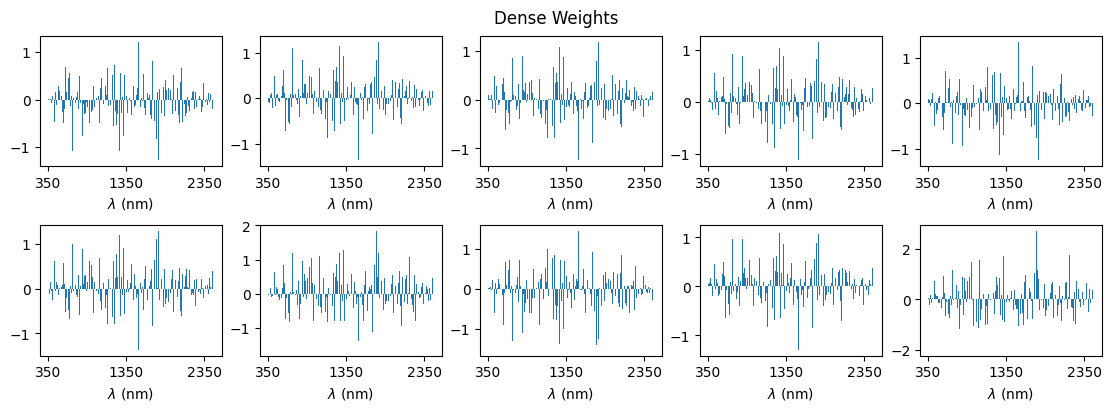

In [121]:
fig, axs = plt.subplots(2, 5, figsize=(11,4), constrained_layout=True)

i = 0
for row in axs:
    for ax in row:
        dense_weights = ae_model.get_layer(index=0).weights[0].numpy()[:,i]
        xrange = np.arange(0, dense_weights.shape[0], 1)
        ax.bar(xrange, dense_weights, align='edge')
        step = 200
        ax.set_xticks(xrange[::step], np.array([int(x[1:]) for x in spec_cols[::blur_factor]])[np.arange(0, dense_weights.shape[0], 1)][::step])
        ax.set_xlabel('$\lambda$ (nm)')
        i += 1

fig.suptitle('Dense Weights')

Text(0.5, 0.98, 'Dense Weights')

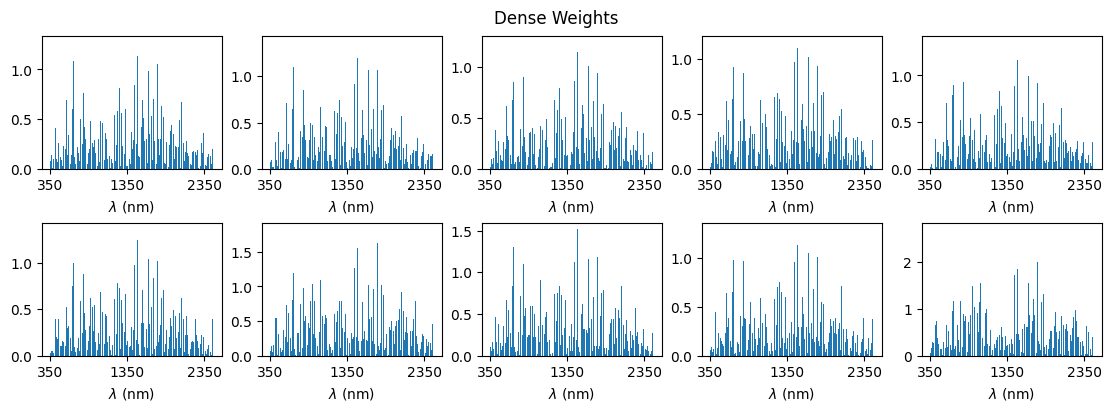

In [122]:
fig, axs = plt.subplots(2, 5, figsize=(11,4), constrained_layout=True)

i = 0
for row in axs:
    for ax in row:
        dense_weights = ae_model.get_layer(index=0).weights[0].numpy()[:,i]
        xrange = np.arange(0, dense_weights.shape[0], 1)
        ax.bar(xrange, np.abs(dense_weights), align='edge')
        step = 200
        ax.set_xticks(xrange[::step], np.array([int(x[1:]) for x in spec_cols[::blur_factor]])[np.arange(0, dense_weights.shape[0], 1)][::step])
        ax.set_xlabel('$\lambda$ (nm)')
        i += 1

fig.suptitle('Dense Weights')

In [47]:
ae_model.get_layer(index=0).weights[0].numpy().shape

(424, 10)

### CNN

In [48]:
model = Sequential([
    Conv1D(20, 20, input_shape=(x_train.shape[1],1), kernel_regularizer=L2(.001)),
    MaxPooling1D(),
    Flatten(),
    Dense(20, kernel_regularizer=L2(.001)),
    Dense(20, kernel_regularizer=L2(.01)),
    Dense(1)
])

model.compile(optimizer=Adam(.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
def schedule(epochs, lr):
    if epochs < 10:
       return lr
    else:
        return 1e-4

In [50]:
history = model.fit(
    cnn_reshape(x_train),
    y_train,
    epochs=30,
    validation_data=(cnn_reshape(x_val), y_val),
)

Epoch 1/30
592/592 [==============================] - 3s 4ms/step - loss: 0.9196 - accuracy: 0.5928 - val_loss: 0.8261 - val_accuracy: 0.6752
Epoch 2/30
592/592 [==============================] - 2s 3ms/step - loss: 0.7798 - accuracy: 0.7404 - val_loss: 0.7365 - val_accuracy: 0.7665
Epoch 3/30
592/592 [==============================] - 2s 3ms/step - loss: 0.7006 - accuracy: 0.7633 - val_loss: 0.6674 - val_accuracy: 0.7589
Epoch 4/30
592/592 [==============================] - 2s 3ms/step - loss: 0.6484 - accuracy: 0.7639 - val_loss: 0.6377 - val_accuracy: 0.7732
Epoch 5/30
592/592 [==============================] - 2s 3ms/step - loss: 0.6103 - accuracy: 0.7709 - val_loss: 0.5963 - val_accuracy: 0.7713
Epoch 6/30
592/592 [==============================] - 2s 3ms/step - loss: 0.5771 - accuracy: 0.7791 - val_loss: 0.5621 - val_accuracy: 0.7775
Epoch 7/30
592/592 [==============================] - 2s 3ms/step - loss: 0.5489 - accuracy: 0.7873 - val_loss: 0.5514 - val_accuracy: 0.7876
Epoch 

(0.0, 1.0)

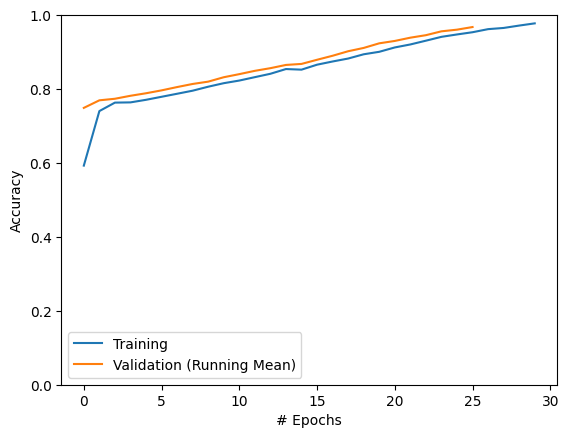

In [51]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))

Text(0.5, 0.98, 'CNN Kernels')

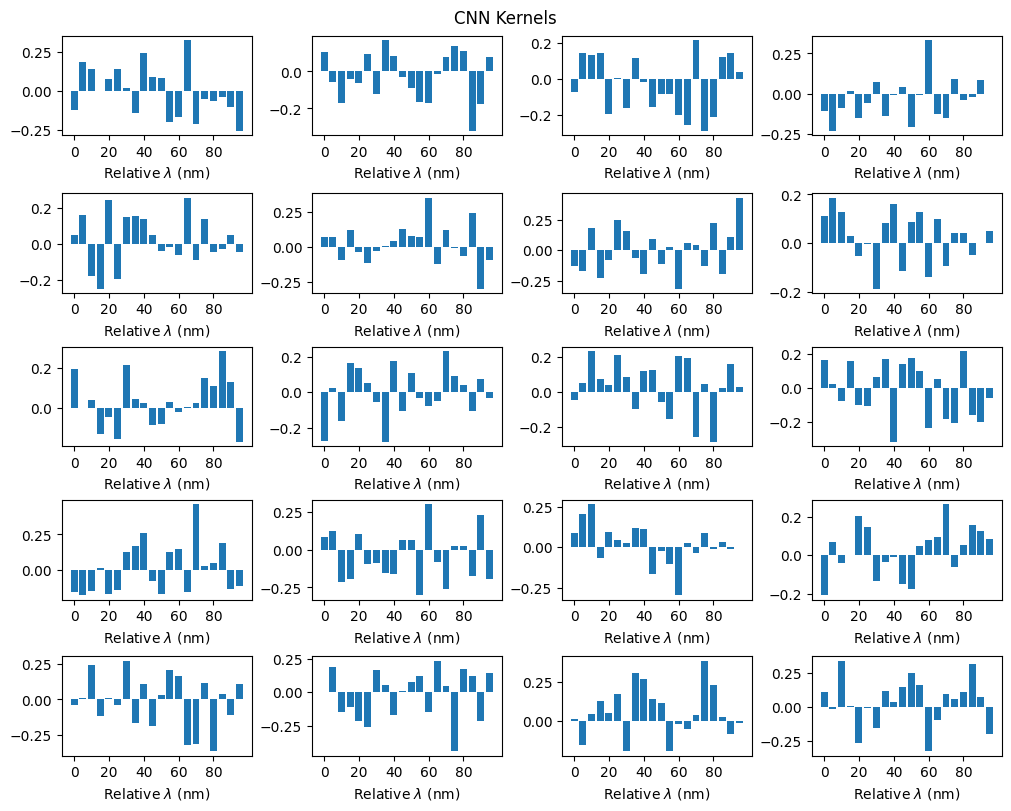

In [130]:

fig, axs = plt.subplots(5, 4, figsize=(10,8), constrained_layout=True)

i = 0
for row in axs:
    for ax in row:
        cnn_weights = model.get_layer(index=0).weights[0].numpy()[i][0]
        xrange = np.arange(0, cnn_weights.shape[0], 1)
        ax.bar(xrange, cnn_weights)
        ax.set_xticks(xrange[::4], (xrange*blur_factor)[::4])
        ax.set_xlabel('Relative $\lambda$ (nm)')
        i += 1

fig.suptitle('CNN Kernels')

In [53]:
temp = cnn_reshape(x)
for i in range(5):
    temp = model.get_layer(index=i)(temp)

In [54]:
ae_pca = PCA(n_components=2)
temp_pca = ae_pca.fit_transform(temp.numpy())

Text(0.5, 1.0, 'PCA first 2 dims')

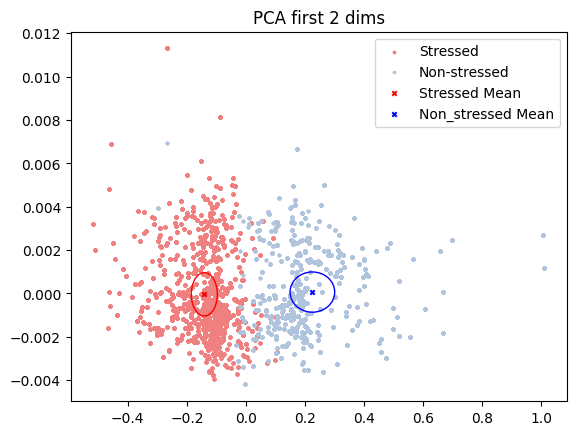

In [55]:
x_pca = temp_pca

fig = plt.figure()
ax = plt.gca()

ax.scatter(x_pca[df['Stressed'].values][:,0], x_pca[df['Stressed'].values][:,1], s=3, c='lightcoral', label='Stressed')
ax.scatter(x_pca[~df['Stressed'].values][:,0], x_pca[~df['Stressed'].values][:,1], s=3, c='lightsteelblue', label='Non-stressed')

ax.scatter(x_pca[df['Stressed'].values][:,0].mean(), x_pca[df['Stressed'].values][:,1].mean(), s=10, c='red', label='Stressed Mean', marker='x')
ax.scatter(x_pca[~df['Stressed'].values][:,0].mean(), x_pca[~df['Stressed'].values][:,1].mean(), s=10, c='blue', label='Non_stressed Mean', marker='x')


stressed_ellipse = Ellipse(
    xy=x_pca[df['Stressed'].values][:,:2].mean(axis=0),
    width=x_pca[df['Stressed'].values][:,0].std(),
    height=x_pca[df['Stressed'].values][:,1].std(),
    fill=False,
    edgecolor='red',
)

non_stressed_ellipse = Ellipse(
    xy=x_pca[~df['Stressed'].values][:,:2].mean(axis=0),
    width=x_pca[~df['Stressed'].values][:,0].std(),
    height=x_pca[~df['Stressed'].values][:,1].std(),
    fill=False,
    edgecolor='blue'
)


ax.add_patch(stressed_ellipse)
ax.add_patch(non_stressed_ellipse)

ax.legend()
ax.set_title('PCA first 2 dims')
# ax.set_xlim((-2, 2))
# ax.set_ylim((-1, 1.5))

In [56]:
cnn_pred = model.predict(x)

740/740 [==============================] - 1s 2ms/step


In [57]:
cnn_pred_scaled = ((cnn_pred - cnn_pred.min()) / (cnn_pred.max() - cnn_pred.min()))[:,0]
cnn_confidence = np.abs(cnn_pred_scaled - .5) * 2

Text(0, 0.5, 'Count')

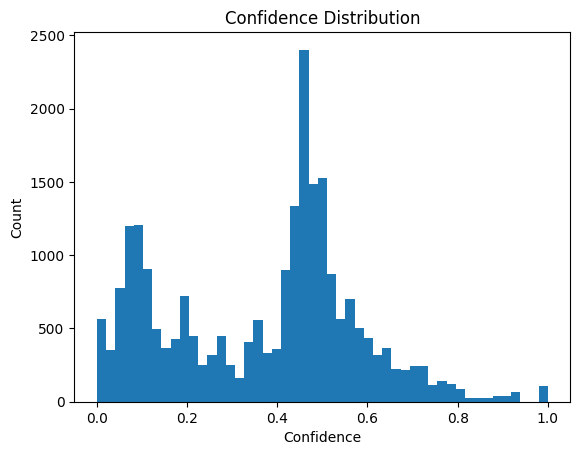

In [58]:
bins = np.linspace(0, 1, 50)
conf_hist, _ = np.histogram(cnn_confidence, bins=bins)
plt.hist(cnn_confidence, bins=bins);
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')

In [59]:
df[cnn_confidence < .05]['Time'].value_counts(), df[cnn_confidence < .05]['Stressed'].value_counts()

(Time
 0    972
 2    219
 1     59
 Name: count, dtype: int64,
 Stressed
 False    1250
 Name: count, dtype: int64)

### SVM

In [60]:
svm = SVC(verbose=True, kernel='linear')
svm.fit(x_train, y_train)

[LibSVM]

SVC(kernel='linear', verbose=True)

In [61]:
y_pred = svm.predict(x_val)

In [62]:
(y_pred == y_val).mean()

0.7764158918005072

Text(0.5, 1.0, 'SVM Linear Coefficients (Absolute)')

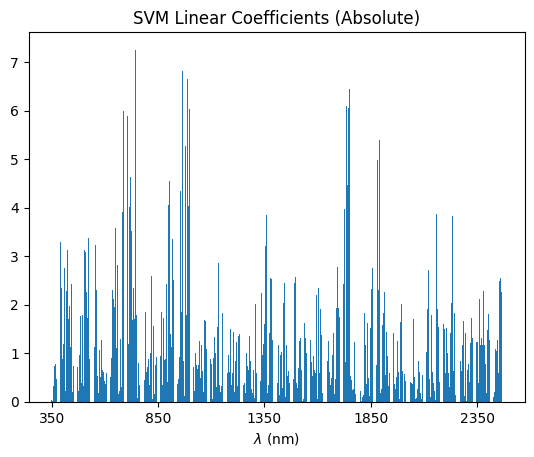

In [138]:
fig, ax = plt.subplots()
xrange = np.arange(0, svm.coef_.shape[1], 1)
ax.bar(xrange, np.abs(svm.coef_[0]))
ax.set_xticks(xrange[::100], np.array([int(x[1:]) for x in spec_cols[::blur_factor]])[xrange[::100]])
ax.set_xlabel('$\lambda$ (nm)')
ax.set_title('SVM Linear Coefficients (Absolute)')